Import necessary packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve
import re
import nltk
from collections import Counter
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize
from xgboost import XGBClassifier
from sentiment_module import sentiment
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [2]:
# Read in data as a .tsv
alexa = pd.read_csv(r'C:\Users\Christian\Documents\Personal Projects\amazon_alexa.tsv', delimiter='\t')

Exploratory Analysis

In [3]:
# Look at the distribution of rating scores
alexa.groupby('rating').describe()

feedback                                   
          count mean  std  min  25%  50%  75%  max
rating                                            
1         161.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
2          96.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
3         152.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0
4         455.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0
5        2286.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0

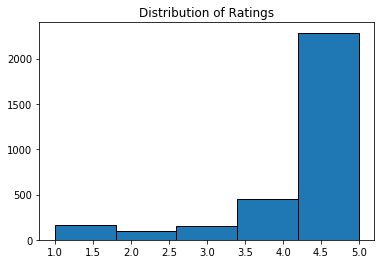

In [4]:
# Create histogram of the distribution of ratings
plt.clf()
plt.hist(alexa['rating'], bins=5, ec='black')
plt.title('Distribution of Ratings')
plt.show()

In [5]:
# Look at the distribution of feedback scores
alexa.groupby('feedback').describe()

rating                                             
           count      mean       std  min  25%  50%  75%  max
feedback                                                     
0          257.0  1.373541  0.484688  1.0  1.0  1.0  2.0  2.0
1         2893.0  4.737643  0.546544  3.0  5.0  5.0  5.0  5.0

So we can gather that the feedback score is simply whether the ratings are <=2 or >2

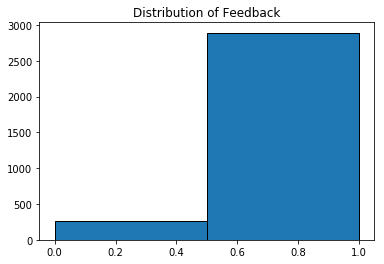

In [6]:
# Create histogram of the distribution of feedback
plt.clf()
plt.hist(alexa['feedback'], bins=2, ec='black')
plt.title('Distribution of Feedback')
plt.show()

In [7]:
# Create a variable that is the character length of each review
alexa['length'] = alexa['verified_reviews'].apply(len)

In [8]:
# Check what the length of the first review is
alexa['length'][0]

13

In [9]:
# Double check to see that it is correct
alexa['verified_reviews'][0]

'Love my Echo!'

Huzzah! It seems to be working.

<Figure size 432x288 with 0 Axes>

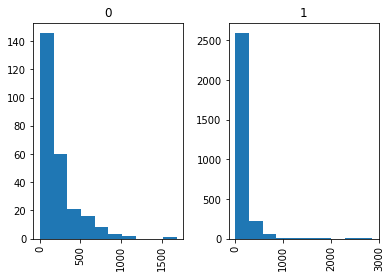

In [10]:
# Look at the distribution of length per reveiw by the feedback
plt.clf()
alexa.hist(column='length', by='feedback')
plt.show()

In [11]:
blanks = alexa[alexa['length'] == 1 ]

In [12]:
blanks.shape

(81, 6)

It appears as thought there are 81 reviews that do not contain a single letter character, we will want to remove these as they provide no text insight

In [13]:
alexa = alexa[alexa['length'] > 1 ]

In [14]:
by_variation = alexa.groupby('variation').mean()[['rating']]
by_variation = by_variation.sort_values(by='rating')

<Figure size 432x288 with 0 Axes>

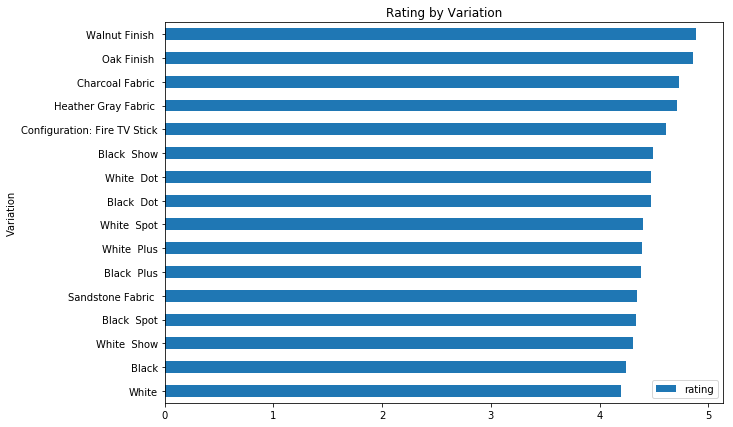

In [15]:
plt.clf()
by_variation.plot.barh(figsize=(10,7))
plt.title('Rating by Variation')
plt.ylabel('Variation')
plt.show()

It appears as though all of the reviews are positive with a very slight variation between products

Create a Bag of Words for each of the rating scores

In [16]:
one = alexa[alexa['rating'] == 1 ]
two = alexa[alexa['rating'] == 2 ]
three = alexa[alexa['rating'] == 3 ]
four = alexa[alexa['rating'] == 4 ]
five = alexa[alexa['rating'] == 5 ]

In [17]:
by_rating = [one, two, three, four, five]

In [18]:
stopwords = nltk.corpus.stopwords.words('english')
added_stopwords = ['alexa', 'amazon', 'dot', 'echo']
stopwords.extend(added_stopwords)
rating_bow = []
rating_wc = []

for i in range(0,5):
    all_tokens = [word_tokenize(t) for t in by_rating[i]['verified_reviews']]

    # Make all of the strings lowercase
    all_tokens = [t.lower() for list in all_tokens for t in list]

    # Keep only strings that contain alphabetic characters
    all_tokens = [t for t in all_tokens if t.isalpha()]

    # Remove stopwords
    all_tokens = [t for t in all_tokens if t not in stopwords]

    # Lemmatize the remaining strings
    wnl = WordNetLemmatizer()
    all_tokens = [wnl.lemmatize(t) for t in all_tokens]

    # Create a bag of words using the Counter() function, and look at the top 10 most common words
    bow = Counter(all_tokens)
    rating_bow.append(bow.most_common(40))
    by_rating_text = " ".join(review for review in by_rating[i]['verified_reviews'])
    rating_wc.append(by_rating_text)
    

In [19]:
text = " ".join(review for review in alexa['verified_reviews'])

Word Cloud of all of the reviews

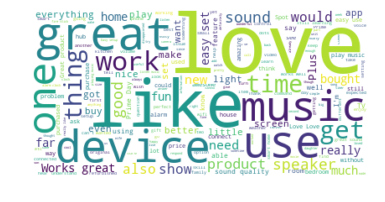

In [20]:
wordcloud = WordCloud(stopwords = stopwords, background_color='white').generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Word Cloud of the 5 star reviews

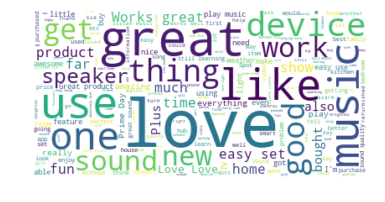

In [21]:
wordcloud = WordCloud(stopwords = stopwords, background_color='white').generate(rating_wc[4])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Word Cloud of the 4 star reviews

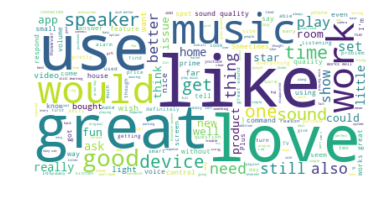

In [22]:
wordcloud = WordCloud(stopwords = stopwords, background_color='white').generate(rating_wc[3])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Word Cloud of the 3 star reviews

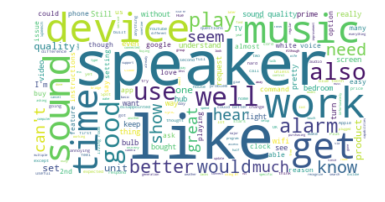

In [23]:
wordcloud = WordCloud(stopwords = stopwords, background_color='white').generate(rating_wc[2])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Word Cloud of the 2 star reviews

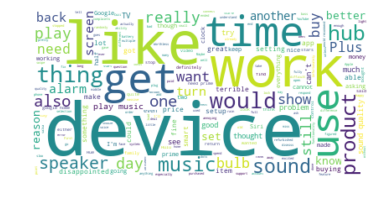

In [24]:
wordcloud = WordCloud(stopwords = stopwords, background_color='white').generate(rating_wc[1])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Word Cloud of the 1 star reviews

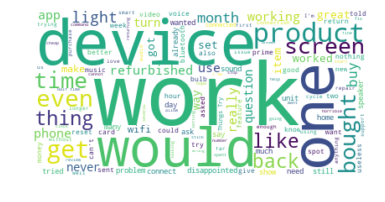

In [25]:
wordcloud = WordCloud(stopwords = stopwords, background_color='white').generate(rating_wc[0])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Going to try to predict the feedback score of reviews using XGBoost

In [26]:
corpus=[]
ps=PorterStemmer()
stopwords = nltk.corpus.stopwords.words('english')

for i in range(0, len(alexa['verified_reviews'])):
    # Keep only strings that begin with a alphabetic character
    review = re.sub('[^a-zA-Z]', ' ', alexa.iloc[i,3] )
    # Make review lowercase, and then split the review into individual tokens
    review = review.lower().split()
    # Porter stem the tokens of the review, while removing the stopwords
    review = [ps.stem(word) for word in review if word not in stopwords]
    # Combine the tokens into a single string
    review = ' '.join(review)
    # Append that string to the corpus
    corpus.append(review)

In [27]:
# Initialize a CountVectorizor using only the top 1500 terms, and using a mix of unigrams and bigrams
vec = CountVectorizer(max_features=1500)

In [28]:
# Creating the predictor and response variables X and y
X = vec.fit_transform(corpus).toarray()
y = alexa['feedback'].values

# Splitting the data into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10, test_size=0.25)

In [29]:
# Initialize an XGBoost classifier
xgb = XGBClassifier()

# Fit that classifier onto the training data
xgb.fit(X_train, y_train)

# Using the trained model, predict on the predictor test data
y_pred = xgb.predict(X_test)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [30]:
# Print the confusion matrix to check the results
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[  6  45]
 [  3 714]]


Assuming that a Positive Value corresponds to a Feedback score of 1:

In [31]:
Accuracy = (cm[0][0]+cm[1][1])/(cm[0][0]+cm[0][1]+cm[1][0]+cm[1][1])
Recall = cm[1][1]/(sum(cm[1]))
Precision = cm[1][1]/(cm[1][1]+cm[0][1])

In [32]:
print('Accuracy: {}'.format(Accuracy.round(3)))
print('Recall: {}'.format(Recall.round(3)))
print('Precision: {}'.format(Precision.round(3)))

Accuracy: 0.938
Recall: 0.996
Precision: 0.941


Compare Accuracy versus a Benchmark model that would predict every review to have a Feedback Score of 1

In [33]:
Benchmark_Accuracy = cm[1][1]/(cm[0][0]+cm[0][1]+cm[1][0]+cm[1][1])
print('Benchmark Accuracy: {}'.format(Benchmark_Accuracy.round(2)))

Benchmark Accuracy: 0.93


In [34]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(corpus).toarray()

In [35]:
# Splitting the data into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10, test_size=0.25)

# Initialize an XGBoost classifier
xgb = XGBClassifier()

# Fit that classifier onto the training data
xgb.fit(X_train, y_train)

# Using the trained model, predict on the predictor test data
y_pred = xgb.predict(X_test)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [36]:
# Print the confusion matrix to check the results
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[  4  47]
 [  3 714]]


Time to perform Sentiment Analysis

In [37]:
# Create term vector list
term_vec = []

for c in corpus:
    term_vec.append(nltk.word_tokenize(c))

In [38]:
# Create dataframe that contains the contents of the review, the rating, feedback, and sentiment scores for valence and arousal
df_sent = pd.DataFrame(columns=['Review','Rating', 'Feedback', 'Valence', 'Arousal'])

# Create for loop that will append the contents of each row to the empty dataframe
for i in range(0, len(term_vec)):
    row_dict = {}
    row_dict['Review'] = alexa.iloc[i,3]
    row_dict['Rating'] = alexa.iloc[i,0]
    row_dict['Feedback'] = alexa.iloc[i,4]
    # Calculate the valence and arousal of the terms in the current row of term_vec
    review_sentiment = sentiment.sentiment(term_vec[i])
    # Extract just the valence score
    row_dict['Valence'] = review_sentiment['valence']
    # Extract just the arousal score
    row_dict['Arousal'] = review_sentiment['arousal']
    # Append row_dict to the dataframe
    df_sent = df_sent.append(row_dict, ignore_index=True)

In [39]:
df_sent = df_sent[df_sent['Valence'] != 0]

In [40]:
df_sent.sort_values(by='Valence').tail(20)

,Review,Rating,Feedback,Valence,Arousal
836,Love it,5,1,8.72,6.44
822,Love it,5,1,8.72,6.44
818,I love having an Alexa!,5,1,8.72,6.44
815,Love our echo,5,1,8.72,6.44
1766,Love it,5,1,8.72,6.44
1794,Love everything about this....,5,1,8.72,6.44
2725,love it,5,1,8.72,6.44
1799,Love it it's number 4!,5,1,8.72,6.44
786,Love it!,5,1,8.72,6.44
2918,love it,4,1,8.72,6.44


In [41]:
df_sent.sort_values(by='Valence').head(20)

,Review,Rating,Feedback,Valence,Arousal
1357,Fairly useless.,2,0,2.130000,4.870000
527,Amazon doesn't disappoint.,5,1,2.390000,4.920000
362,I’m never disappointed with amazons technology.,5,1,2.390000,4.920000
2978,I'm addicted to this thing.,5,1,2.480000,5.660000
2640,I'm addicted to this thing.,5,1,2.480000,5.660000
1364,Invasive and scared the crap out of me for spe...,1,0,3.141777,6.169813
500,No problems,5,1,3.520000,4.810000
1194,no problem,5,1,3.520000,4.810000
794,The outlet does not work with it. Was disappoi...,4,1,3.549322,4.434286
107,The outlet does not work with it. Was disappoi...,4,1,3.549322,4.434286


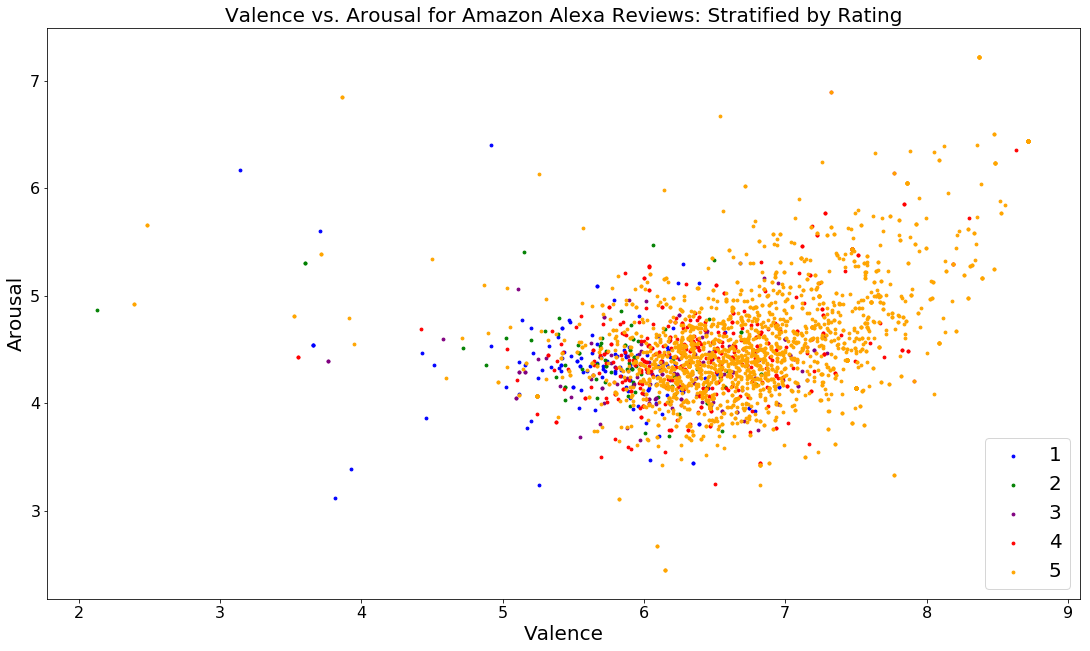

In [42]:
plt.clf()
plt.scatter('Valence', 'Arousal', data=df_sent[df_sent['Rating'] == 1], c='blue', s=8, label='1')
plt.scatter('Valence', 'Arousal', data=df_sent[df_sent['Rating'] == 2], c='green', s=8, label='2')
plt.scatter('Valence', 'Arousal', data=df_sent[df_sent['Rating'] == 3], c='purple', s=8, label='3')
plt.scatter('Valence', 'Arousal', data=df_sent[df_sent['Rating'] == 4], c='red', s=8, label='4')
plt.scatter('Valence', 'Arousal', data=df_sent[df_sent['Rating'] == 5], c='orange', s=8, label='5')
plt.legend(loc='lower right', prop={'size': 20})
fig = plt.gcf()
plt.title('Valence vs. Arousal for Amazon Alexa Reviews: Stratified by Rating', fontsize=20)
plt.tick_params(labelsize=16)
plt.xlabel('Valence', fontsize=20)
plt.ylabel('Arousal', fontsize=20)
fig.set_size_inches(18.5, 10.5)

plt.show()

In [43]:
df_sent.groupby('Rating').mean()[['Valence', 'Arousal']]

,Valence,Arousal
Rating,,
1,5.725649,4.348546
2,5.840446,4.396256
3,6.209994,4.315217
4,6.500291,4.502437
5,6.865589,4.656022


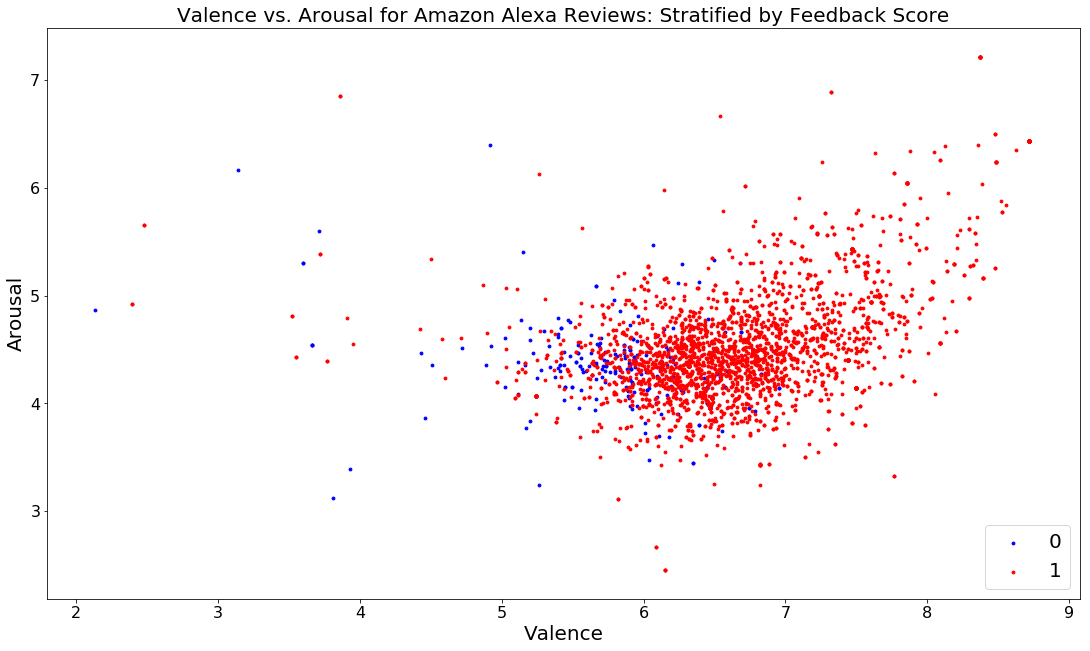

In [44]:
plt.clf()
plt.scatter('Valence', 'Arousal', data=df_sent[df_sent['Feedback'] == 0], c='blue', s=8, label='0')
plt.scatter('Valence', 'Arousal', data=df_sent[df_sent['Feedback'] == 1], c='red', s=8, label='1')

plt.legend(loc='lower right', prop={'size': 20})
fig = plt.gcf()
plt.title('Valence vs. Arousal for Amazon Alexa Reviews: Stratified by Feedback Score', fontsize=20)
plt.tick_params(labelsize=16)
plt.xlabel('Valence', fontsize=20)
plt.ylabel('Arousal', fontsize=20)
fig.set_size_inches(18.5, 10.5)

plt.show()

In [45]:
df_sent.groupby('Feedback').mean()[['Valence', 'Arousal']]

,Valence,Arousal
Feedback,,
0,5.770265,4.367089
1,6.776167,4.615181
